In [2]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns

np.random.seed(2020)

In [14]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

from tensorflow.keras.utils import to_categorical # convert to one-hot-encoding
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.datasets import mnist

sns.set(style='white', context='notebook', palette='deep')

In [8]:
train = pd.read_csv('./Data/train.csv')
test = pd.read_csv('./Data/test.csv')
sub = pd.read_csv('./Data/sample_submission.csv')


In [10]:
print(f"Training data size is {train.shape}\nTesting data size is {test.shape}")

Training data size is (42000, 785)
Testing data size is (28000, 784)


In [11]:
Y_train = train["label"]
X_train = train.drop(labels = ["label"], axis = 1) 

In [15]:
(x_train1, y_train1), (x_test1, y_test1) = mnist.load_data()

train1 = np.concatenate([x_train1, x_test1], axis=0)
y_train1 = np.concatenate([y_train1, y_test1], axis=0)

Y_train1 = y_train1
X_train1 = train1.reshape(-1, 28*28)

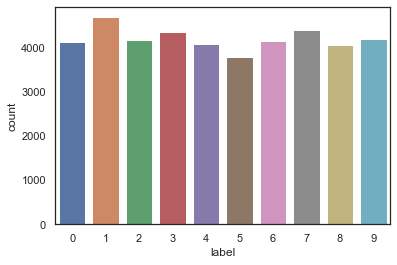

In [16]:
# Print data histogram
sns.countplot(Y_train);

In [17]:
# Normalize data to make CNN faster
X_train = X_train / 255.0
test = test / 255.0
X_train1 = X_train1 / 255.0

In [18]:
# Reshape Picture is 3D array (height = 28px, width = 28px , canal = 1)
X_train = np.concatenate((X_train.values, X_train1))
Y_train = np.concatenate((Y_train, Y_train1))

In [19]:
# Reshape image in 3 dimensions (height = 28px, width = 28px , canal = 1)
# canal = 1 => For gray scale
X_train = X_train.reshape(-1,28,28,1)
test = test.values.reshape(-1,28,28,1)

In [20]:
# Convert label to one hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_train = to_categorical(Y_train, num_classes = 10)

In [21]:
# Split the train and the validation set for the fitting
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size = 0.1, random_state=2)

In [22]:
X_train.shape, X_val.shape, Y_train.shape, Y_val.shape

((100800, 28, 28, 1), (11200, 28, 28, 1), (100800, 10), (11200, 10))

In [24]:
#Creating CNN model
"""
  [[Conv2D->relu]*2 -> BatchNormalization -> MaxPool2D -> Dropout]*2 -> 
  [Conv2D->relu]*2 -> BatchNormalization -> Dropout -> 
  Flatten -> Dense -> BatchNormalization -> Dropout -> Out
"""
model = Sequential()

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu', input_shape = (28,28,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())

model.add(Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same',  activation ='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(BatchNormalization())
model.add(Dropout(0.25))

model.add(Dense(10, activation = "softmax"))

In [32]:
# Define Optimizer
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)

In [34]:
# Compile model
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [35]:
# Audjusting learning rate
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [45]:
#Adjusting epochs and batch_size
epochs = 50
batch_size = 128

In [37]:
#Data Augmentation 
datagen = ImageDataGenerator(
        featurewise_center=False, # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

#datagen.fit(X_train)
train_gen = datagen.flow(X_train,Y_train, batch_size=batch_size)

In [46]:
#Prediction model
history = model.fit(train_gen,
                              epochs = epochs,validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction],
                             validation_steps = X_val.shape[0] // batch_size)

Epoch 1/50
787/787 - 20s - loss: 0.0282 - accuracy: 0.9913 - val_loss: 0.0194 - val_accuracy: 0.9937 - lr: 0.0010 - 20s/epoch - 25ms/step
Epoch 2/50
787/787 - 19s - loss: 0.0254 - accuracy: 0.9923 - val_loss: 0.0173 - val_accuracy: 0.9954 - lr: 0.0010 - 19s/epoch - 25ms/step
Epoch 3/50
787/787 - 19s - loss: 0.0248 - accuracy: 0.9924 - val_loss: 0.0133 - val_accuracy: 0.9955 - lr: 0.0010 - 19s/epoch - 24ms/step
Epoch 4/50
787/787 - 20s - loss: 0.0234 - accuracy: 0.9930 - val_loss: 0.0165 - val_accuracy: 0.9953 - lr: 0.0010 - 20s/epoch - 25ms/step
Epoch 5/50
787/787 - 19s - loss: 0.0216 - accuracy: 0.9937 - val_loss: 0.0158 - val_accuracy: 0.9953 - lr: 0.0010 - 19s/epoch - 25ms/step
Epoch 6/50
787/787 - 19s - loss: 0.0215 - accuracy: 0.9934 - val_loss: 0.0128 - val_accuracy: 0.9966 - lr: 0.0010 - 19s/epoch - 25ms/step
Epoch 7/50
787/787 - 19s - loss: 0.0205 - accuracy: 0.9939 - val_loss: 0.0121 - val_accuracy: 0.9965 - lr: 0.0010 - 19s/epoch - 24ms/step
Epoch 8/50
787/787 - 19s - loss: 0

In [47]:
# Predict the values from the validation dataset
Y_pred = model.predict(X_val)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(Y_val,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

In [48]:
# Make predictions about test sets
results = model.predict(test)

# Convert one-hot vector to number
results = np.argmax(results,axis = 1)

results = pd.Series(results,name="Label")

In [49]:
# Save the final result in cnn_mnist_submission.csv
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)

submission.to_csv("cnn_mnist_submission.csv",index=False)